<br>
<br>
* In this notebook, the predictive model takes the last three hours' data to forecast the price change in percentage 15 minutes from now. 
* It will not be able to make predictions before the noon of a trading day, because it will not have three hours' data by then.
* It is easy to change the code in order to forecast the price change for a longer period.
* It is trained on 30000 training cases sampled from the month of August, and tested on data sampled from the two weeks immediatedly after August.

In [129]:
import pandas as pd
import numpy as np

import pickle
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import scipy.stats as st

<br>
<br>
Notice that some data is not used in this analysis, because it is likely to be redundant.

In [176]:
close_returns_raw = pd.read_csv('dataset/close_returns.csv', index_col = 0, parse_dates = True)
high_prices_raw = pd.read_csv('dataset/high_prices.csv', index_col = 0, parse_dates = True)
low_prices_raw = pd.read_csv('dataset/low_prices.csv', index_col = 0, parse_dates = True)
volume_raw = pd.read_csv('dataset/volume.csv', index_col = 0, parse_dates = True)
signals_A_raw = pd.read_csv('dataset/signals_A.csv', index_col = 0, parse_dates = True)
signals_B_raw = pd.read_csv('dataset/signals_B.csv', index_col = 0, parse_dates = True)

<br>
<br>
Each stock's volume is normalised by its median volume of the year. The volume_normalised is a dataframe.

In [177]:
median_volume_each_stock = volume_raw.median(axis = 0)
volume_normalised = volume_raw.apply(lambda x: x / median_volume_each_stock, axis=1)

<br>
<br>
A crude way to measure volatility. Now we have volatility dataframe.

In [178]:
volatility = (high_prices_raw - low_prices_raw) / low_prices_raw

<br>
<br>
#### Group by day and fill NA

Forward filling, maximum 4 x 15 mins gap of missing data. Not to fill the next day by previous day's data.

In [180]:
def intra_day_forward_fillna_max_filling_1_hour_gap(dataframe):
    return dataframe.groupby(dataframe.index.dayofyear).apply(
        lambda x: x.fillna(method = "ffill", axis = 0, limit = 2))

With hindsight, the NA filling step could have been skipped. We can wait until after the tidy df is formed and then delete any row that has missing values. We will not suffer from wasting too much data, and there are benefits not fillna: 
1. There is no data shortage in this case; there is too much data so that sampling is needed to reduce training time, 
2. Filling NA introduces noise and bias, 
3. When a stock has missing values, perhaps it is due to the stock not being traded; we do not want to trade small cap.

In [181]:
volume_normalised_filled = intra_day_forward_fillna_max_filling_1_hour_gap(volume_normalised)
volatility_filled = intra_day_forward_fillna_max_filling_1_hour_gap(volatility)
signal_A_raw_filled = intra_day_forward_fillna_max_filling_1_hour_gap(signals_A_raw)
signal_B_raw_filled = intra_day_forward_fillna_max_filling_1_hour_gap(signals_B_raw)

In [8]:
close_returns_raw_filled = close_returns_raw.groupby(close_returns_raw.index.dayofyear).apply(
    lambda x: x.fillna(value = 0.0, axis = 0)) 
# Different from "ffill", if use "limit" here, it would specify maximum 
# total number of 0 that can be used to pad each col. Not what we want.

<br>
<br>
List of dataframes each is the yearly data of a stock (five columns)

In [183]:
list_of_df_each_for_one_stock = [pd.concat([#close_returns_raw_filled.iloc[:, a],
                                            close_returns_raw.iloc[:, a],
                                            volume_normalised_filled.iloc[:, a],
                                            volatility_filled.iloc[:, a],
                                            signal_A_raw_filled.iloc[:, a],
                                            signal_B_raw_filled.iloc[:, a]], axis = 1)
                                 for a in range(1000)] # Total 1000 stocks

<br>
<br>
Rename each dataframe.

In [184]:
for e in list_of_df_each_for_one_stock:
    e.columns = ["return", "volume", "volatility", "signal_A", "signal_B"]               

<br>
<br>
Take a look.

In [185]:
list_of_df_each_for_one_stock[0].head()

,return,volume,volatility,signal_A,signal_B
time,,,,,
2017-01-03 09:30:00,NaN,1.357828,0.011823,NaN,NaN
2017-01-03 09:45:00,-0.010530,0.840949,0.003595,-0.012937,NaN
2017-01-03 10:00:00,-0.005218,1.191392,0.005506,-0.004742,NaN
2017-01-03 10:15:00,0.004456,0.554745,0.004171,-0.001138,NaN
2017-01-03 10:30:00,-0.001799,0.484170,0.004360,0.003315,NaN


In [186]:
list_of_df_each_for_one_stock[0].tail()

,return,volume,volatility,signal_A,signal_B
time,,,,,
2017-12-29 14:45:00,-0.014195,0.389359,0.000930,-0.014027,0.678396
2017-12-29 15:00:00,-0.005576,0.359596,0.001627,-0.006361,0.653249
2017-12-29 15:15:00,0.006572,0.628543,0.002169,0.005638,1.139014
2017-12-29 15:30:00,-0.005632,1.039431,0.001703,-0.003321,1.790983
2017-12-29 15:45:00,0.011733,5.173711,0.002170,0.011734,6.585453


<br>
<br>
<br>

In [187]:
list_of_df_by_stock_by_day_grouped = [x.groupby(x.index.dayofyear) 
                                      for x in list_of_df_each_for_one_stock]

Remember previously there is a list of dataframes each is the yearly data of a stock (five columns). The list_of_df_by_stock_by_day is a list of dataframes each is the **daily** data of a stock (five columns). 

In [188]:
list_of_df_by_stock_by_day = [x.get_group(a) 
                              for x in list_of_df_by_stock_by_day_grouped 
                              for a in x.groups]

In [189]:
list_of_df_by_stock_by_day[0].tail()

,return,volume,volatility,signal_A,signal_B
time,,,,,
2017-01-03 14:45:00,0.002773,1.267860,0.001912,0.002390,1.559230
2017-01-03 15:00:00,-0.006562,0.902536,0.002672,-0.008265,1.130021
2017-01-03 15:15:00,0.001064,0.785697,0.002004,0.003739,0.969713
2017-01-03 15:30:00,-0.008516,1.212756,0.002479,-0.010592,1.432389
2017-01-03 15:45:00,0.003238,4.798810,0.005139,-0.000370,4.572557


<br>
<br>
Remember previously there is a list of dataframes each is the daily data of a stock. 
<br>
The list_of_df_by_stock_by_window_flatten is a list of dataframes each is a sliding window of 13 x 15 minutes size over the daily data of a stock. 
<br>
As you will see in the later process, the first 12 x 15 minutes will be features. For the last 1 x 15 minutes, all other values will be discarded, * except the "return" which is what to be forecasted. *
<br>
The total number of dataframes in list_of_df_by_stock_by_window_flatten should be: * number of sliding windows per day x number of days x number of stocks. *  

In [190]:
window_size = 13

def get_list_of_window_sized_df(df):
    return [df.iloc[i: i + window_size] for i in range(len(df.index) - window_size + 1)]

In [191]:
list_of_df_by_stock_by_window = [get_list_of_window_sized_df(x) 
                                 for x in list_of_df_by_stock_by_day]

In [192]:
list_of_df_by_stock_by_window_flatten = [window 
                                         for by_stock_by_day in list_of_df_by_stock_by_window
                                         for window in by_stock_by_day]

<br>
<br>
An example of such windows.

In [193]:
list_of_df_by_stock_by_window_flatten[0]

,return,volume,volatility,signal_A,signal_B
time,,,,,
2017-01-03 09:30:00,NaN,1.357828,0.011823,NaN,NaN
2017-01-03 09:45:00,-0.010530,0.840949,0.003595,-0.012937,NaN
2017-01-03 10:00:00,-0.005218,1.191392,0.005506,-0.004742,NaN
2017-01-03 10:15:00,0.004456,0.554745,0.004171,-0.001138,NaN
2017-01-03 10:30:00,-0.001799,0.484170,0.004360,0.003315,NaN
2017-01-03 10:45:00,-0.001767,0.742527,0.002465,-0.004975,NaN
2017-01-03 11:00:00,0.000046,1.119380,0.003421,0.002896,NaN
2017-01-03 11:15:00,0.004687,0.694956,0.001901,0.003925,NaN
2017-01-03 11:30:00,-0.003899,0.841778,0.003386,-0.004027,NaN


<br>
<br>
The next step is to transform each window into a row. The list_of_df_by_stock_by_window_flatten_reindexed_unstacked is a list of such rows.

In [194]:
# Will take 3 hours
# Use window.reset_index().unstack().to_frame().T will take 5 hours
list_of_df_by_stock_by_window_flatten_reindexed_unstacked = \
    [window.reset_index().unstack()
     for window in list_of_df_by_stock_by_window_flatten]

<br>
<br>
Concatenate rows into a dataframe.

In [195]:
# Will take 2 hours
tidy_table = pd.concat(list_of_df_by_stock_by_window_flatten_reindexed_unstacked, axis=1).T

In [196]:
tidy_table.shape

(3506000, 78)

In [197]:
tidy_table.head()

time                                            \
                    0                    1                    2    
0  2017-01-03 09:30:00  2017-01-03 09:45:00  2017-01-03 10:00:00   
1  2017-01-03 09:45:00  2017-01-03 10:00:00  2017-01-03 10:15:00   
2  2017-01-03 10:00:00  2017-01-03 10:15:00  2017-01-03 10:30:00   
3  2017-01-03 10:15:00  2017-01-03 10:30:00  2017-01-03 10:45:00   
4  2017-01-03 10:30:00  2017-01-03 10:45:00  2017-01-03 11:00:00   

                                                                  \
                    3                    4                    5    
0  2017-01-03 10:15:00  2017-01-03 10:30:00  2017-01-03 10:45:00   
1  2017-01-03 10:30:00  2017-01-03 10:45:00  2017-01-03 11:00:00   
2  2017-01-03 10:45:00  2017-01-03 11:00:00  2017-01-03 11:15:00   
3  2017-01-03 11:00:00  2017-01-03 11:15:00  2017-01-03 11:30:00   
4  2017-01-03 11:15:00  2017-01-03 11:30:00  2017-01-03 11:45:00   

                                                                  \
                    6                    7                    8    
0  2017-01-03 11:00:00  2017-01-03 11:15:00  2017-01-03 11:30:00   
1  2017-01-03 11:15:00  2017-01-03 11:30:00  2017-01-03 11:45:00   
2  2017-01-03 11:30:00  2017-01-03 11:45:00  2017-01-03 12:00:00   
3  2017-01-03 11:45:00  2017-01-03 12:00:00  2017-01-03 12:15:00   
4  2017-01-03 12:00:00  2017-01-03 12:15:00  2017-01-03 12:30:00   

                          ...    signal_B                                    \
                    9     ...          3    4        5         6         7    
0  2017-01-03 11:45:00    ...         NaN  NaN      NaN       NaN       NaN   
1  2017-01-03 12:00:00    ...         NaN  NaN      NaN       NaN       NaN   
2  2017-01-03 12:15:00    ...         NaN  NaN      NaN       NaN   1.15869   
3  2017-01-03 12:30:00    ...         NaN  NaN      NaN   1.15869  0.773829   
4  2017-01-03 12:45:00    ...         NaN  NaN  1.15869  0.773829   0.75454   

                                                     
         8         9         10        11        12  
0       NaN   1.15869  0.773829   0.75454   1.99192  
1   1.15869  0.773829   0.75454   1.99192  0.594899  
2  0.773829   0.75454   1.99192  0.594899  0.799001  
3   0.75454   1.99192  0.594899  0.799001   0.47083  
4   1.99192  0.594899  0.799001   0.47083  0.701983  

[5 rows x 78 columns]

<br>
<br>
Save the result.

In [198]:
with open('tidy_table_return_not_filled.pickle', 'wb') as handle:
    pickle.dump(tidy_table, handle, protocol = pickle.HIGHEST_PROTOCOL)

#with open('tidy_table_return_not_filled.pickle', 'rb') as handle:
#    tidy_table = pickle.load(handle)

<br>
<br>
Flatten the index.

In [199]:
tidy_table.columns = [col[0] + '_' + str(col[1]) for col in tidy_table.columns.values]

<br>
<br>
Drop useless columns and * drop any row that has any missing value. *

In [200]:
tidy_table_dropped = tidy_table.drop(['time_0', 'time_1', 'time_2', 'time_3', 'time_4', 'time_5',
                                      'time_6', 'time_7', 'time_8', 'time_9', 'time_10', 'time_11',
                                      'volume_12', 'volatility_12', 'signal_A_12', 'signal_B_12'], axis = 1)\
                               .dropna(axis = 0)

In [201]:
tidy_table_dropped.shape

(2711538, 62)

<br>
<br>
Notice that "return_12" is the value to be predicted.

In [202]:
tidy_table_dropped.columns.values

array(['time_12', 'return_0', 'return_1', 'return_2', 'return_3',
       'return_4', 'return_5', 'return_6', 'return_7', 'return_8',
       'return_9', 'return_10', 'return_11', 'return_12', 'volume_0',
       'volume_1', 'volume_2', 'volume_3', 'volume_4', 'volume_5',
       'volume_6', 'volume_7', 'volume_8', 'volume_9', 'volume_10',
       'volume_11', 'volatility_0', 'volatility_1', 'volatility_2',
       'volatility_3', 'volatility_4', 'volatility_5', 'volatility_6',
       'volatility_7', 'volatility_8', 'volatility_9', 'volatility_10',
       'volatility_11', 'signal_A_0', 'signal_A_1', 'signal_A_2',
       'signal_A_3', 'signal_A_4', 'signal_A_5', 'signal_A_6',
       'signal_A_7', 'signal_A_8', 'signal_A_9', 'signal_A_10',
       'signal_A_11', 'signal_B_0', 'signal_B_1', 'signal_B_2',
       'signal_B_3', 'signal_B_4', 'signal_B_5', 'signal_B_6',
       'signal_B_7', 'signal_B_8', 'signal_B_9', 'signal_B_10',
       'signal_B_11'], dtype=object)

<br>
<br>
Define a function to generate more features. Specifically:
* Rowing sum of 2 x 15 minutes window size
* Rowing sum of 4 x 15 minutes window size
* Rowing sum of 8 x 15 minutes window size
* Rowing sum of 12 x 15 minutes window size

In [203]:
def add_more_rolling_features(df, string):
    df[string + "_0_1"] = df[string + "_0"] + df[string + "_1"]
    df[string + "_1_2"] = df[string + "_1"] + df[string + "_2"]
    df[string + "_2_3"] = df[string + "_2"] + df[string + "_3"]
    df[string + "_3_4"] = df[string + "_3"] + df[string + "_4"]
    df[string + "_4_5"] = df[string + "_4"] + df[string + "_5"]
    df[string + "_5_6"] = df[string + "_5"] + df[string + "_6"]
    df[string + "_6_7"] = df[string + "_6"] + df[string + "_7"]
    df[string + "_7_8"] = df[string + "_7"] + df[string + "_8"]
    df[string + "_8_9"] = df[string + "_8"] + df[string + "_9"]
    df[string + "_9_10"] = df[string + "_9"] + df[string + "_10"]
    df[string + "_10_11"] = df[string + "_10"] + df[string + "_11"]
    
    df[string + "_0_to_3"] = df[string + "_0"] + df[string + "_1"] + df[string + "_2"] + df[string + "_3"]
    df[string + "_1_to_4"] = df[string + "_1"] + df[string + "_2"] + df[string + "_3"] + df[string + "_4"]
    df[string + "_2_to_5"] = df[string + "_2"] + df[string + "_3"] + df[string + "_4"] + df[string + "_5"]
    df[string + "_3_to_6"] = df[string + "_3"] + df[string + "_4"] + df[string + "_5"] + df[string + "_6"]
    df[string + "_4_to_7"] = df[string + "_4"] + df[string + "_5"] + df[string + "_6"] + df[string + "_7"]
    df[string + "_5_to_8"] = df[string + "_5"] + df[string + "_6"] + df[string + "_7"] + df[string + "_8"]
    df[string + "_6_to_9"] = df[string + "_6"] + df[string + "_7"] + df[string + "_8"] + df[string + "_9"]
    df[string + "_7_to_10"] = df[string + "_7"] + df[string + "_8"] + df[string + "_9"] + df[string + "_10"]
    df[string + "_8_to_11"] = df[string + "_8"] + df[string + "_9"] + df[string + "_10"] + df[string + "_11"]
    
    df[string + "_0_to_7"] = df[string + "_0"] + df[string + "_1"] + df[string + "_2"] + df[string + "_3"] +\
                             df[string + "_4"] + df[string + "_5"] + df[string + "_6"] + df[string + "_7"]
    df[string + "_1_to_8"] = df[string + "_1"] + df[string + "_2"] + df[string + "_3"] + df[string + "_4"] +\
                             df[string + "_5"] + df[string + "_6"] + df[string + "_7"] + df[string + "_8"]
    df[string + "_2_to_9"] = df[string + "_2"] + df[string + "_3"] + df[string + "_4"] + df[string + "_5"] +\
                             df[string + "_6"] + df[string + "_7"] + df[string + "_8"] + df[string + "_9"]
    df[string + "_3_to_10"] = df[string + "_3"] + df[string + "_4"] + df[string + "_5"] + df[string + "_6"] +\
                              df[string + "_7"] + df[string + "_8"] + df[string + "_9"] + df[string + "_10"]
    df[string + "_4_to_11"] = df[string + "_4"] + df[string + "_5"] + df[string + "_6"] + df[string + "_7"] +\
                              df[string + "_8"] + df[string + "_9"] + df[string + "_10"] + df[string + "_11"]
    
    df[string + "_0_to_11"] = df[string + "_0"] + df[string + "_1"] + df[string + "_2"] + df[string + "_3"] +\
                              df[string + "_4"] + df[string + "_5"] + df[string + "_6"] + df[string + "_7"] +\
                              df[string + "_8"] + df[string + "_9"] + df[string + "_10"] + df[string + "_11"]
    return df

<br>
<br>
Apply this feature generation function to all five types of features.
<br>
Additionally:
* "hour" might be a useful feature. 
* "dayofweek" might be useful if the training data is from a longer time window, but with a window of just one month, it may introduce bias.

In [204]:
tidy_more_features = tidy_table_dropped.assign(hour = lambda x: x["time_12"].apply(lambda x: x.hour))#,
#                                               dayofweek = lambda x: x["time_12"].apply(lambda x: x.dayofweek))
tidy_more_features = add_more_rolling_features(tidy_more_features, "return")
tidy_more_features = add_more_rolling_features(tidy_more_features, "volume")
tidy_more_features = add_more_rolling_features(tidy_more_features, "volatility")
tidy_more_features = add_more_rolling_features(tidy_more_features, "signal_A")
tidy_more_features = add_more_rolling_features(tidy_more_features, "signal_B")

<br>
<br>
As the rowing sum of 2 x 15 minutes window size already exist, delete some granular columns.

In [205]:
tidy_more_features = tidy_more_features.drop(
      ['return_0', 'return_1', 'return_2', 'return_3', 'return_4', 'return_5', 
       'return_6', 'return_7', #'return_8', 'return_9', 'return_10',                         
       'volume_0', 'volume_1', 'volume_2', 'volume_3', 'volume_4', 'volume_5',
       'volume_6', 'volume_7', #'volume_8', 'volume_9', 'volume_10',
       'volatility_0', 'volatility_1', 'volatility_2', 'volatility_3', 'volatility_4', 'volatility_5', 
       'volatility_6', 'volatility_7', #'volatility_8', 'volatility_9', 'volatility_10',
       'signal_A_0', 'signal_A_1', 'signal_A_2', 'signal_A_3', 'signal_A_4', 'signal_A_5', 
       'signal_A_6', 'signal_A_7', #'signal_A_8', 'signal_A_9', 'signal_A_10',
       'signal_B_0', 'signal_B_1', 'signal_B_2', 'signal_B_3', 'signal_B_4', 'signal_B_5', 
       'signal_B_6', 'signal_B_7'#, 'signal_B_8', 'signal_B_9', 'signal_B_10'
      ], axis = 1)

In [206]:
tidy_more_features.shape

(2711538, 153)

<br>
<br>
"time_12" is the time associated with "return_12", and "return_12" is the value to be predicted.
<br>
Train on 30000 training cases sampled from the month of August, and test on data sampled from the two weeks immediatedly after August.

In [207]:
tidy_more_features = tidy_more_features.reset_index(drop = True)
start_of_aug = datetime.strptime('2017-08-01 06:00:00', '%Y-%m-%d %H:%M:%S')
end_of_aug = datetime.strptime('2017-08-31 18:00:00', '%Y-%m-%d %H:%M:%S')
mid_of_sep = datetime.strptime('2017-09-15 18:00:00', '%Y-%m-%d %H:%M:%S')
train_data = tidy_more_features.loc[start_of_aug < tidy_more_features['time_12']].\
                                loc[tidy_more_features['time_12'] < end_of_aug].sample(n = 30000)
test_data = tidy_more_features.loc[end_of_aug < tidy_more_features['time_12']].\
                               loc[tidy_more_features['time_12'] < mid_of_sep].sample(n = 10000)

<br>
<br>
No longer need the time column, so drop it. The apply(pd.to_numeric) is for assurance.

In [208]:
train_data = train_data.drop("time_12", axis = 1).apply(pd.to_numeric)
test_data = test_data.drop("time_12", axis = 1).apply(pd.to_numeric)

In [209]:
train_data.shape

(30000, 152)

In [210]:
test_data.shape

(10000, 152)

In [211]:
train_data.columns.values

array(['return_8', 'return_9', 'return_10', 'return_11', 'return_12',
       'volume_8', 'volume_9', 'volume_10', 'volume_11', 'volatility_8',
       'volatility_9', 'volatility_10', 'volatility_11', 'signal_A_8',
       'signal_A_9', 'signal_A_10', 'signal_A_11', 'signal_B_8',
       'signal_B_9', 'signal_B_10', 'signal_B_11', 'hour', 'return_0_1',
       'return_1_2', 'return_2_3', 'return_3_4', 'return_4_5',
       'return_5_6', 'return_6_7', 'return_7_8', 'return_8_9',
       'return_9_10', 'return_10_11', 'return_0_to_3', 'return_1_to_4',
       'return_2_to_5', 'return_3_to_6', 'return_4_to_7', 'return_5_to_8',
       'return_6_to_9', 'return_7_to_10', 'return_8_to_11',
       'return_0_to_7', 'return_1_to_8', 'return_2_to_9',
       'return_3_to_10', 'return_4_to_11', 'return_0_to_12', 'volume_0_1',
       'volume_1_2', 'volume_2_3', 'volume_3_4', 'volume_4_5',
       'volume_5_6', 'volume_6_7', 'volume_7_8', 'volume_8_9',
       'volume_9_10', 'volume_10_11', 'volume_0_to_3', '

<br>
<br>

# Model building

* Randomized combination of hyper-parameters.
* Find the best hyper-parameter setting based on the result of five-fold cross validation.
* Again, "return_12" is the "y variable" column.

In [212]:
params = {
    "n_estimators" : [30],
    "max_features" : ["auto", "sqrt", "log2"],
    "max_depth" : [25, 30, 35],
    "min_samples_split" : [2, 3, 5],
    "min_samples_leaf" : [1, 2, 3]
}

model = RandomForestRegressor(n_jobs = -1)

gs = RandomizedSearchCV(estimator = model, 
                        param_distributions = params, 
                        n_jobs = -1, 
                        n_iter = 12,
                        cv = 5,
                        return_train_score = False)

gs.fit(train_data.loc[:, train_data.columns != "return_12"], train_data.loc[:, "return_12"])

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=12, n_jobs=-1,
          param_distributions={'n_estimators': [30], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [25, 30, 35], 'min_samples_split': [2, 3, 5], 'min_samples_leaf': [1, 2, 3]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=False, scoring=None, verbose=0)

In [213]:
print(datetime.now())

2018-09-23 10:28:57.776439


<br>
<br>
Print out the cv result and pick the best hyper-parameter setting

In [214]:
#pd.DataFrame.from_dict(gs.cv_results_)
gs.grid_scores_

C:\Users\wangka3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.25492, std: 0.01358, params: {'n_estimators': 30, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 30},
 mean: 0.25690, std: 0.01386, params: {'n_estimators': 30, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 35},
 mean: 0.25665, std: 0.00975, params: {'n_estimators': 30, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 35},
 mean: 0.24840, std: 0.01174, params: {'n_estimators': 30, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 35},
 mean: 0.25242, std: 0.01265, params: {'n_estimators': 30, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30},
 mean: 0.24656, std: 0.01313, params: {'n_estimators': 30, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30},
 mean: 0.25019, std: 0.01520, params: {'n_estimators': 30, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_f

<br>
<br>
Initiate a RandomForestRegressor model based on the best hyper-parameter setting.

In [215]:
best_model = RandomForestRegressor(
    n_estimators = 30,
    max_features = "log2",
    max_depth = 30,
    min_samples_split = 3,
    min_samples_leaf = 2,
    n_jobs = -1    
)

<br>
<br>
Train the model on the entire training set.

In [216]:
best_model.fit(train_data.loc[:, train_data.columns != "return_12"], train_data.loc[:, "return_12"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

<br>
<br>
Predict

In [217]:
prediction = best_model.predict(test_data.loc[:, test_data.columns != "return_12"])

<br>
<br>
Setting the plot size

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

<br>
<br>
How is the prediction

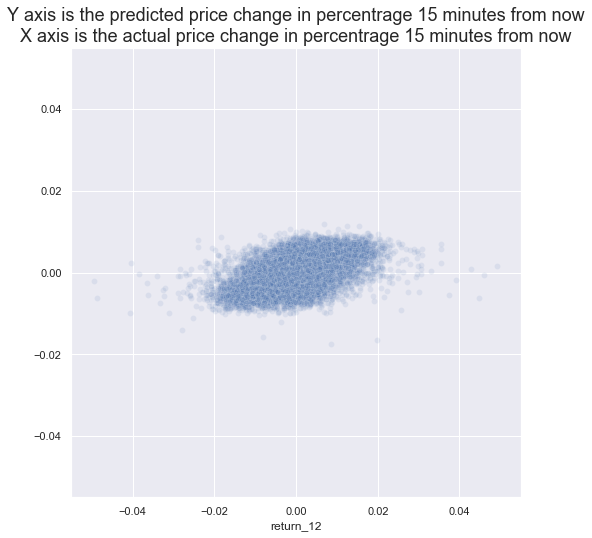

In [233]:
pyplot.axis('scaled')
sns.scatterplot(x = test_data.loc[:, "return_12"], y = prediction, alpha = 0.1).\
set_title('Y axis is the predicted price change in percentrage 15 minutes from now\n\
X axis is the actual price change in percentrage 15 minutes from now',fontsize = 18);

<br>
<br>
Measure in a single number

In [219]:
root_mean_square_error = mean_squared_error(test_data.loc[:, "return_12"], prediction) ** 0.5
root_mean_square_error

0.007989223865426429

<br>
<br>
Feature importance. Notice that only the top 30 most important features are displayed.

Feature ranking:
1. feature return_11 (0.046046)
2. feature return_10_11 (0.039833)
3. feature signal_A_11 (0.035331)
4. feature signal_A_8_to_11 (0.031156)
5. feature return_8_to_11 (0.029383)
6. feature return_4_to_11 (0.027730)
7. feature signal_A_10_11 (0.022817)
8. feature return_0_to_12 (0.020617)
9. feature signal_A_0_to_12 (0.017797)
10. feature signal_A_4_to_11 (0.017669)
11. feature return_4_to_7 (0.007885)
12. feature return_10 (0.007474)
13. feature signal_A_10 (0.007296)
14. feature return_8_9 (0.007293)
15. feature signal_A_8_9 (0.007096)
16. feature signal_A_8 (0.006990)
17. feature return_8 (0.006964)
18. feature signal_A_0_to_7 (0.006959)
19. feature volatility_10_11 (0.006588)
20. feature return_9_10 (0.006577)
21. feature signal_A_4_to_7 (0.006492)
22. feature signal_A_9_10 (0.006484)
23. feature signal_A_7_to_10 (0.006482)
24. feature volatility_5_6 (0.006420)
25. feature return_7_to_10 (0.006367)
26. feature volatility_11 (0.006281)
27. feature volatility_9_10 (0.0

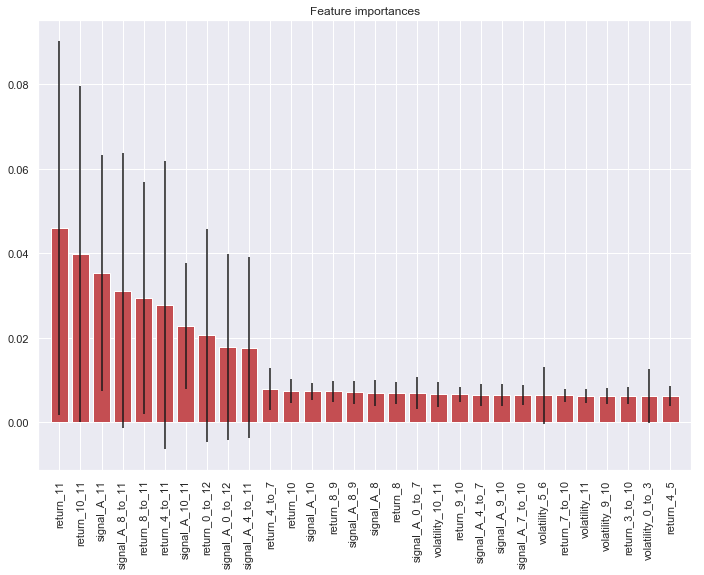

In [224]:
X = test_data.loc[:, test_data.columns != "return_12"]

importances = best_model.feature_importances_

std = np.std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)

indices = np.argsort(importances)[::-1][0:30]

# Print the feature ranking
print("Feature ranking:")

for f in range(30):
    print("%d. feature %s (%f)" % (f + 1, X.columns.values[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
pyplot.figure()
pyplot.title("Feature importances")
pyplot.bar(range(30), importances[indices], color="r", yerr=std[indices], align="center")
pyplot.xticks(range(30), X.columns.values[indices], rotation= 90)
pyplot.xlim([-1, 30])
pyplot.show()

In [167]:
params = {
    "n_estimators": [30],
    "max_depth": st.randint(10, 20),
    "learning_rate": st.uniform(0.2, 0.7),
    "colsample_bytree": st.uniform(0.60, 0.40),
    "subsample": st.uniform(0.6, 0.4),
    "gamma": st.uniform(0.2, 1.6),
    "min_child_weight": [0,1,2,3,4],
    "max_delta_step": [0, 1, 2, 3, 4]
}

model = XGBRegressor(n_jobs = -1)

gs = RandomizedSearchCV(estimator = model, 
                        param_distributions = params, 
                        n_jobs = -1, 
                        n_iter = 12,
                        cv = 5,
                        return_train_score = False)

gs.fit(train_data.loc[:, train_data.columns != "return_12"], train_data.loc[:, "return_12"])

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=12, n_jobs=-1,
          param_distributions={'n_estimators': [30], 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000245679B59B0>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000245319A36D8>, 'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at ...ject at 0x0000024564979A20>, 'min_child_weight': [0, 1, 2, 3, 4], 'max_delta_step': [0, 1, 2, 3, 4]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          

In [169]:
gs.grid_scores_

C:\Users\wangka3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.00038, std: 0.00043, params: {'colsample_bytree': 0.7335872258124142, 'gamma': 0.628475160652294, 'learning_rate': 0.60695847039054, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 30, 'subsample': 0.8761730534361889},
 mean: -0.00034, std: 0.00045, params: {'colsample_bytree': 0.9847518930392336, 'gamma': 0.8092206795450152, 'learning_rate': 0.705179589182275, 'max_delta_step': 1, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 30, 'subsample': 0.7986126553979606},
 mean: -0.00038, std: 0.00045, params: {'colsample_bytree': 0.7039956875557987, 'gamma': 0.9800730182131427, 'learning_rate': 0.6857487051605708, 'max_delta_step': 4, 'max_depth': 10, 'min_child_weight': 0, 'n_estimators': 30, 'subsample': 0.8675097613496994},
 mean: -0.00038, std: 0.00045, params: {'colsample_bytree': 0.9415042684540654, 'gamma': 0.8452633826162887, 'learning_rate': 0.4803547911460402, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 4, 'n_estimators'

In [170]:
best_model = XGBRegressor(
    n_estimators = 30,
    max_depth = 19,
    learning_rate = 0.65,
    colsample_bytree = 0.98,
    subsample = 0.72,
    gamma = 1,
    min_child_weight = 0,
    max_delta_step = 3,
    n_jobs = -1    
)

In [171]:
best_model.fit(train_data.loc[:, train_data.columns != "return_12"], train_data.loc[:, "return_12"])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.98, gamma=1, learning_rate=0.65,
       max_delta_step=3, max_depth=19, min_child_weight=0, missing=None,
       n_estimators=30, n_jobs=-1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.72)

In [172]:
prediction = best_model.predict(test_data.loc[:, test_data.columns != "return_12"])

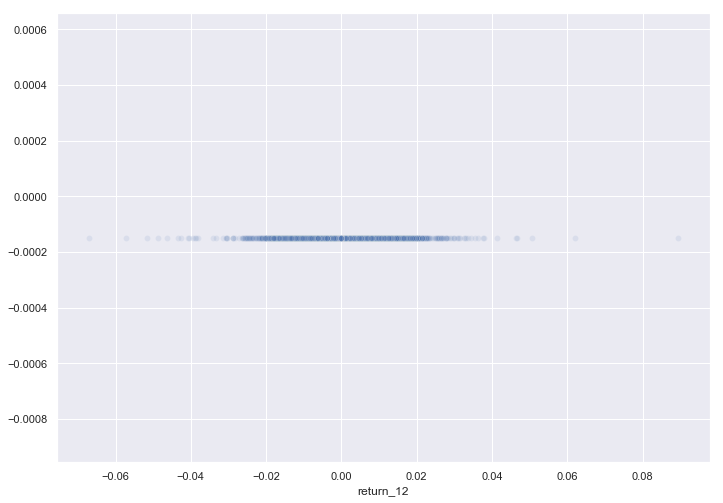

In [173]:
#pyplot.axis('scaled')
sns.scatterplot(x = test_data.loc[:, "return_12"], y = prediction, alpha = 0.1)

In [174]:
root_mean_square_error = mean_squared_error(test_data.loc[:, "return_12"], prediction) ** 0.5
root_mean_square_error

0.009245757169364413

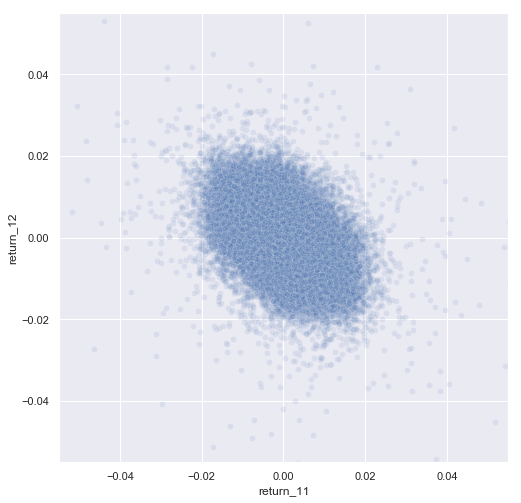

In [234]:
pyplot.axis('scaled')
sns.scatterplot(x = "return_11", y = "return_12", data = train_data, alpha = 0.1);

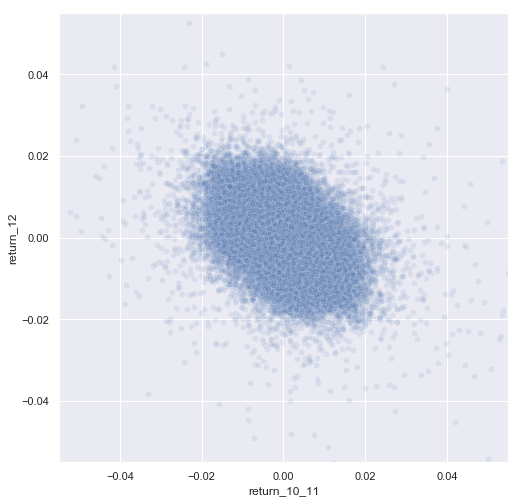

In [235]:
pyplot.axis('scaled')
sns.scatterplot(x = "return_10_11", y = "return_12", data = train_data, alpha = 0.1);

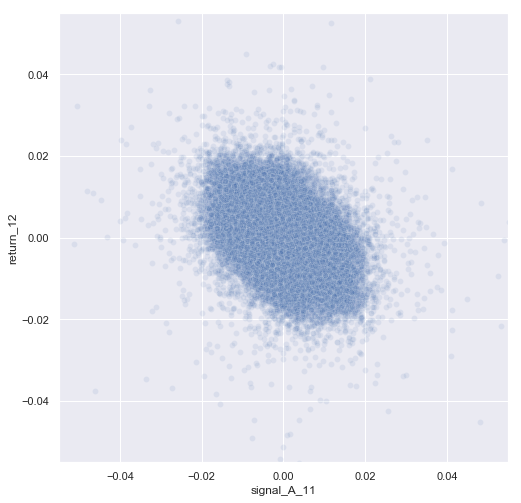

In [236]:
pyplot.axis('scaled')
sns.scatterplot(x = "signal_A_11", y = "return_12", data = train_data, alpha = 0.1);

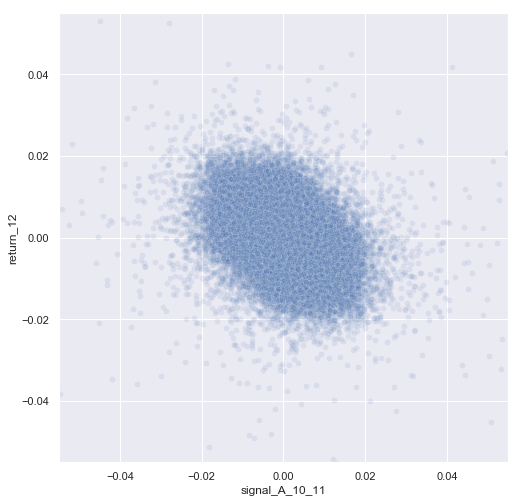

In [237]:
pyplot.axis('scaled')
sns.scatterplot(x = "signal_A_10_11", y = "return_12", data = train_data, alpha = 0.1);

In [ ]:
tidy_more_features["return_0_1"] = tidy_more_features["return_0"] + tidy_more_features["return_1"]
tidy_more_features["return_1_2"] = tidy_more_features["return_1"] + tidy_more_features["return_2"]
tidy_more_features["return_2_3"] = tidy_more_features["return_2"] + tidy_more_features["return_3"]
tidy_more_features["return_3_4"] = tidy_more_features["return_3"] + tidy_more_features["return_4"]
tidy_more_features["return_4_5"] = tidy_more_features["return_4"] + tidy_more_features["return_5"]
tidy_more_features["return_5_6"] = tidy_more_features["return_5"] + tidy_more_features["return_6"]
tidy_more_features["return_6_7"] = tidy_more_features["return_6"] + tidy_more_features["return_7"]
tidy_more_features["return_7_8"] = tidy_more_features["return_7"] + tidy_more_features["return_8"]
tidy_more_features["return_8_9"] = tidy_more_features["return_8"] + tidy_more_features["return_9"]
tidy_more_features["return_9_10"] = tidy_more_features["return_9"] + tidy_more_features["return_10"]
tidy_more_features["return_10_11"] = tidy_more_features["return_10"] + tidy_more_features["return_11"]

tidy_more_features["volume_0_1"] = tidy_more_features["volume_0"] + tidy_more_features["volume_1"]
tidy_more_features["volume_1_2"] = tidy_more_features["volume_1"] + tidy_more_features["volume_2"]
tidy_more_features["volume_2_3"] = tidy_more_features["volume_2"] + tidy_more_features["volume_3"]
tidy_more_features["volume_3_4"] = tidy_more_features["volume_3"] + tidy_more_features["volume_4"]
tidy_more_features["volume_4_5"] = tidy_more_features["volume_4"] + tidy_more_features["volume_5"]
tidy_more_features["volume_5_6"] = tidy_more_features["volume_5"] + tidy_more_features["volume_6"]
tidy_more_features["volume_6_7"] = tidy_more_features["volume_6"] + tidy_more_features["volume_7"]
tidy_more_features["volume_7_8"] = tidy_more_features["volume_7"] + tidy_more_features["volume_8"]
tidy_more_features["volume_8_9"] = tidy_more_features["volume_8"] + tidy_more_features["volume_9"]
tidy_more_features["volume_9_10"] = tidy_more_features["volume_9"] + tidy_more_features["volume_10"]
tidy_more_features["volume_10_11"] = tidy_more_features["volume_10"] + tidy_more_features["volume_11"]

tidy_more_features["volatility_0_1"] = tidy_more_features["volatility_0"] + tidy_more_features["volatility_1"]
tidy_more_features["volatility_1_2"] = tidy_more_features["volatility_1"] + tidy_more_features["volatility_2"]
tidy_more_features["volatility_2_3"] = tidy_more_features["volatility_2"] + tidy_more_features["volatility_3"]
tidy_more_features["volatility_3_4"] = tidy_more_features["volatility_3"] + tidy_more_features["volatility_4"]
tidy_more_features["volatility_4_5"] = tidy_more_features["volatility_4"] + tidy_more_features["volatility_5"]
tidy_more_features["volatility_5_6"] = tidy_more_features["volatility_5"] + tidy_more_features["volatility_6"]
tidy_more_features["volatility_6_7"] = tidy_more_features["volatility_6"] + tidy_more_features["volatility_7"]
tidy_more_features["volatility_7_8"] = tidy_more_features["volatility_7"] + tidy_more_features["volatility_8"]
tidy_more_features["volatility_8_9"] = tidy_more_features["volatility_8"] + tidy_more_features["volatility_9"]
tidy_more_features["volatility_9_10"] = tidy_more_features["volatility_9"] + tidy_more_features["volatility_10"]
tidy_more_features["volatility_10_11"] = tidy_more_features["volatility_10"] + tidy_more_features["volatility_11"]

tidy_more_features["signal_A_0_1"] = tidy_more_features["signal_A_0"] + tidy_more_features["signal_A_1"]
tidy_more_features["signal_A_1_2"] = tidy_more_features["signal_A_1"] + tidy_more_features["signal_A_2"]
tidy_more_features["signal_A_2_3"] = tidy_more_features["signal_A_2"] + tidy_more_features["signal_A_3"]
tidy_more_features["signal_A_3_4"] = tidy_more_features["signal_A_3"] + tidy_more_features["signal_A_4"]
tidy_more_features["signal_A_4_5"] = tidy_more_features["signal_A_4"] + tidy_more_features["signal_A_5"]
tidy_more_features["signal_A_5_6"] = tidy_more_features["signal_A_5"] + tidy_more_features["signal_A_6"]
tidy_more_features["signal_A_6_7"] = tidy_more_features["signal_A_6"] + tidy_more_features["signal_A_7"]
tidy_more_features["signal_A_7_8"] = tidy_more_features["signal_A_7"] + tidy_more_features["signal_A_8"]
tidy_more_features["signal_A_8_9"] = tidy_more_features["signal_A_8"] + tidy_more_features["signal_A_9"]
tidy_more_features["signal_A_9_10"] = tidy_more_features["signal_A_9"] + tidy_more_features["signal_A_10"]
tidy_more_features["signal_A_10_11"] = tidy_more_features["signal_A_10"] + tidy_more_features["signal_A_11"]

tidy_more_features["signal_B_0_1"] = tidy_more_features["signal_B_0"] + tidy_more_features["signal_B_1"]
tidy_more_features["signal_B_1_2"] = tidy_more_features["signal_B_1"] + tidy_more_features["signal_B_2"]
tidy_more_features["signal_B_2_3"] = tidy_more_features["signal_B_2"] + tidy_more_features["signal_B_3"]
tidy_more_features["signal_B_3_4"] = tidy_more_features["signal_B_3"] + tidy_more_features["signal_B_4"]
tidy_more_features["signal_B_4_5"] = tidy_more_features["signal_B_4"] + tidy_more_features["signal_B_5"]
tidy_more_features["signal_B_5_6"] = tidy_more_features["signal_B_5"] + tidy_more_features["signal_B_6"]
tidy_more_features["signal_B_6_7"] = tidy_more_features["signal_B_6"] + tidy_more_features["signal_B_7"]
tidy_more_features["signal_B_7_8"] = tidy_more_features["signal_B_7"] + tidy_more_features["signal_B_8"]
tidy_more_features["signal_B_8_9"] = tidy_more_features["signal_B_8"] + tidy_more_features["signal_B_9"]
tidy_more_features["signal_B_9_10"] = tidy_more_features["signal_B_9"] + tidy_more_features["signal_B_10"]
tidy_more_features["signal_B_10_11"] = tidy_more_features["signal_B_10"] + tidy_more_features["signal_B_11"]


In [235]:
window_size = 12
# The first window is from row 0 to 3, i.e. iloc[0: 0 + window_size - 1]
# The last window is from row len(x.index) - window_size + 1 to len(x.index)
# len(x.index) - window_size + 1 is 
#test.apply(lambda x: x.iloc[i: i + k] for i in range(len(x.index) - k + 1))
#test2 = test.apply(lambda x: x.iloc[i: i + window_size] for i in range(len(x.index) - window_size + 1))
#.apply(lambda x: pd.concat([x.iloc[i: i + k] for i in range(len(x.index) - k + 1)]))])
def make_more(df):
    return [df.iloc[i: i + window_size] for i in range(len(df.index) - window_size + 1)]

#test2 = test.apply(lambda x: make_more(df))